#### Final Project: Rick & Morty analysis

# Phase 3: Exploring Data (Laurine)

In [9]:
# imports
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import codecs
import numpy as np

## 1.3. Finding the “favourite words” of the Smith/Sanchez family

**Focus on characters: Rick Sanchez, Morty Smith, Beth Smith, Jerry Smith, Summer Smith**

### REPORT

What the Kaggle study found: https://www.kaggle.com/andradaolteanu/sentiment-analysis-rick-and-morty-scripts (see "most 10 words from the Smith family" plots)

#### 1st approach
- I only used the transcript database of the Kaggle study we found on Sentiment Analysis
- Pre-processing = lower case + exclude characters' name + NLTK tokenization + NLTK lemmatization + remove words with 2 letters or less

**CCL** : 
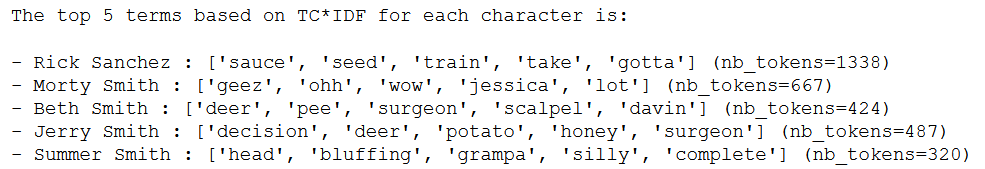

We clearly need more words, especially for Beth, Jerry and Summer! We identify the words from the first episode, when Beth is saving a shot deer.

## Generate data files (tokens)

In [62]:
# load data
df_transcripts = pd.read_csv('transcripts/RickAndMortyScripts.csv')
df_transcripts.head()

,season no.,episode no.,episode name,name,line
0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [63]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)

In [65]:
from os import listdir
from os.path import isfile, join

import nltk
from nltk.tokenize import WordPunctTokenizer

In [66]:
# apply the tokenization process

pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

In [67]:
# get the stopwords list in given language
stopwords = nltk.corpus.stopwords.words('english')
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = nltk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])
    # Save your output for future use
    f = codecs.open('character_words_tokens/'+aFile, "w+", "utf-8")
    f.write(character_page)
    f.close()

## Overview of the whole family words

In [68]:
from nltk.corpus import PlaintextCorpusReader

In [69]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = nltk.Text(familyCorpus.words())

In [70]:
nltk.Text(familyCorpus.words(['Rick Sanchez.txt']))

<Text: gotta come jus gotta come got surprise come...>

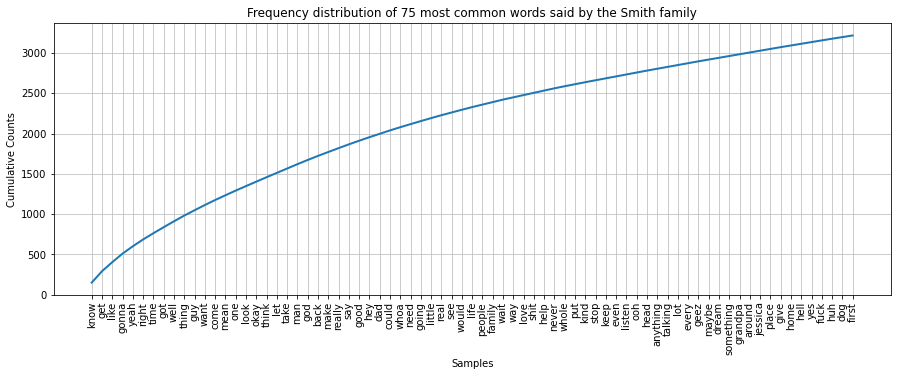

In [71]:
# get the freq distribution of tokens
fdist_family = nltk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

## The favourites words of each character from the Smith family >> TC-IDF

Why TC? Better to plot wordclouds later.

In [72]:
# get one document (of tokens) per character
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [73]:
# compute the TC of each character
char_fdist = {aCharacter:nltk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

The top 5 terms for each character is:

- Rick Sanchez : ['get', 'gonna', 'know', 'like', 'time']
- Morty Smith : ['know', 'like', 'get', 'man', 'right']
- Beth Smith : ['dad', 'know', 'want', 'okay', 'like']
- Jerry Smith : ['know', 'well', 'okay', 'look', 'thing']
- Summer Smith : ['god', 'head', 'grandpa', 'going', 'yeah']


In [74]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [75]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

The top 5 terms based on TC*IDF for each character is:

- Rick Sanchez : ['sauce', 'gotta', 'probably', 'seed', 'piece'] (nb_tokens=1686)
- Morty Smith : ['geez', 'ohh', 'ohhhh', 'cut', 'birdperson'] (nb_tokens=827)
- Beth Smith : ['deer', 'waiting', 'daughter', 'surgeon', 'scalpel'] (nb_tokens=515)
- Jerry Smith : ['potato', 'decision', 'deer', 'based', 'outside'] (nb_tokens=595)
- Summer Smith : ['head', 'silly', 'complete', 'bluffing', 'grampa'] (nb_tokens=384)


# Topic detection